# Validation NTU-RBG+D 60

In [1]:
import os
from pathlib import Path
import sys
from dataclasses import dataclass
import torch
sys.path.append(str(Path(os.getcwd()).parent))

from settings.global_settings import GlobalSettings

config = GlobalSettings.get_config(
    config_file = "../config.ini",
    secrets_file = "../secrets.ini"
)
from dataset.video_loader import VideoDataLoader
from dataset.video_dataset import VideoDataset
from model.multimodal_har_model import MultiModalHARModel
from validation.result_types import ValidationResults, ValidationBranchTuple, DatasetValidation
from validation.quantitative_metrics import evaluate_model
from validation.extract_embeddings import extract_embeddings
from consts.charts_constants import CHARTS_LABELS

Loading config...
Loading secrets...


2026-02-08 10:37:38,491 - INFO - Sentry DSN set to: https://f4f21cc936b3ba9f5dbc1464b7a40ea4@o4504168838070272.ingest.us.sentry.io/4506464560414720
2026-02-08 10:37:38,492 - INFO - Sentry initialized with environment: development


### Defining Support Methods

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

def visualize_tsne(
    reduced_tsne: np.ndarray,
    labels: np.ndarray,
    num_classes: int,
    n_components: int = 2,
    title: str = "t-SNE Visualization"
):
    """
    Plots t-SNE visualization of embeddings in 2D or 3D.
    """
    # Create custom colormap with exactly num_classes colors
    tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    custom_cmap = ListedColormap(tab20_colors[:num_classes])

    if n_components == 2:
        # ---- 2D Visualization ----
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            reduced_tsne[:, 0],
            reduced_tsne[:, 1],
            c=labels,
            cmap=custom_cmap,
            s=40,
            alpha=0.8,
            vmin=0,
            vmax=num_classes-1
        )
        # Force all class ticks to be shown
        cbar = plt.colorbar(scatter)
        cbar.set_ticks(range(num_classes))
        cbar.set_ticklabels(range(num_classes))
        
        plt.title(title)
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.show()

    elif n_components == 3:
        # ---- 3D Visualization ----
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(
            reduced_tsne[:, 0],
            reduced_tsne[:, 1],
            reduced_tsne[:, 2],
            c=labels,
            cmap=custom_cmap,
            s=40,
            alpha=0.85,
            vmin=0,
            vmax=num_classes-1
        )

        # Force all class ticks to be shown
        cbar = fig.colorbar(scatter)
        cbar.set_ticks(range(num_classes))
        cbar.set_ticklabels(range(num_classes))
        
        ax.set_title(title)
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        ax.set_zlabel("t-SNE 3")
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("n_components must be 2 or 3")

**Parameters**

In [3]:
MODELS_PHT = {
    100: {
        # 44 epochs
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_100_with_obj_20251219_101648.pht",
        # 61 epochs
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_100_no_obj_20251219_133000.pht"
    },
    80: {
        # 46 epochs
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_80_with_obj_20251219_200414.pht",
        # 69 epochs
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_80_no_obj_20251220_202014.pht"
    },
    60: {
        # 58 epochs
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_60_with_obj_20251221_122959.pht",
        # 50 epochs
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_60_no_obj_20251221_151301.pht"
    },
    40: {
        # 39 epochs
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_40_with_obj_20251221_174902.pht",
        # 55 epochs
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_40_no_obj_20251221_212948.pht"
    },
    20: {
        # 31 epochs
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_20_with_obj_20251221_224600.pht",
        # 95 epochs
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_20_no_obj_20251222_093017.pht"
    },
}

VALIDATION_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "test"
)

In [4]:
OBSERVATION_RATE = [100, 80, 60, 40, 20]

## Loading Dataset

In [5]:
validation_video_data_loader = VideoDataLoader(
    path=VALIDATION_DIR,
)
validation_dataset = VideoDataset(
    video_data_loader=validation_video_data_loader,
    normalization_type="across_frames",
)

len(validation_dataset)
for _ in validation_dataset:
    pass


display(len(validation_dataset.labels_map))

2026-02-08 10:37:44,618 - INFO - [VideoDataLoader] Loding action videos for action: A001
2026-02-08 10:37:44,681 - INFO - [VideoDataLoader] Loding action videos for action: A002
2026-02-08 10:37:44,738 - INFO - [VideoDataLoader] Loding action videos for action: A004
2026-02-08 10:37:44,808 - INFO - [VideoDataLoader] Loding action videos for action: A006
2026-02-08 10:37:44,856 - INFO - [VideoDataLoader] Loding action videos for action: A011
2026-02-08 10:37:45,011 - INFO - [VideoDataLoader] Loding action videos for action: A012
2026-02-08 10:37:45,077 - INFO - [VideoDataLoader] Loding action videos for action: A013
2026-02-08 10:37:45,137 - INFO - [VideoDataLoader] Loding action videos for action: A014
2026-02-08 10:37:45,221 - INFO - [VideoDataLoader] Loding action videos for action: A015
2026-02-08 10:37:45,303 - INFO - [VideoDataLoader] Loding action videos for action: A020
2026-02-08 10:37:45,470 - INFO - [VideoDataLoader] Loding action videos for action: A021
2026-02-08 10:37:45,5

15

In [6]:
dataset_validation = DatasetValidation(name="NW-UCLA")

## Loading Model

## Running Validation

- Accuracy
- AUC
- Getting Embeddings

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for obs_rate in OBSERVATION_RATE:
    ear_ratio = obs_rate / 100.0
    print(f"Evaluating for observation rate: {obs_rate}% (EAR ratio: {ear_ratio})")
    validation_dataset_obs = VideoDataset(
        video_data_loader=validation_video_data_loader,
        normalization_type="across_frames",
        EAR_ratio=ear_ratio,
    )
    har_model, _ = MultiModalHARModel.load(
        checkpoint_path=MODELS_PHT[obs_rate]["with_obj"]
    )

    har_model_without_object_branch, _ = MultiModalHARModel.load(
        checkpoint_path=MODELS_PHT[obs_rate]["without_obj"]
    )
    
    dataset_validation[obs_rate] = ValidationBranchTuple(
        with_object_branch=ValidationResults(
            quantitative_metrics=evaluate_model(har_model, validation_dataset_obs, device),
            embeddings=extract_embeddings(har_model, validation_dataset_obs, device)
        ),
        without_object_branch=ValidationResults(
            quantitative_metrics=evaluate_model(har_model_without_object_branch, validation_dataset_obs, device),
            embeddings=extract_embeddings(har_model_without_object_branch, validation_dataset_obs, device)
        )
    )


2026-02-08 10:37:47,226 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_100_with_obj_20251219_101648.pht...


Evaluating for observation rate: 100% (EAR ratio: 1.0)


2026-02-08 10:37:47,494 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:37:47,495 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:37:47,552 - INFO - ✅ Model loaded and ready for inference
2026-02-08 10:37:47,554 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_100_no_obj_20251219_133000.pht...
2026-02-08 10:37:47,748 - INFO - Model config: {'obj_in': 5, 'joint_in'

Evaluating for observation rate: 80% (EAR ratio: 0.8)


2026-02-08 10:38:23,291 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:38:23,292 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:38:23,312 - INFO - ✅ Model loaded and ready for inference
2026-02-08 10:38:23,315 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_80_no_obj_20251220_202014.pht...
2026-02-08 10:38:23,505 - INFO - Model config: {'obj_in': 5, 'joint_in':

Evaluating for observation rate: 60% (EAR ratio: 0.6)


2026-02-08 10:38:50,878 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:38:50,879 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:38:50,896 - INFO - ✅ Model loaded and ready for inference
2026-02-08 10:38:50,898 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_60_no_obj_20251221_151301.pht...
2026-02-08 10:38:51,090 - INFO - Model config: {'obj_in': 5, 'joint_in':

Evaluating for observation rate: 40% (EAR ratio: 0.4)


2026-02-08 10:39:10,571 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:39:10,572 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:39:10,588 - INFO - ✅ Model loaded and ready for inference
2026-02-08 10:39:10,590 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_40_no_obj_20251221_212948.pht...
2026-02-08 10:39:10,783 - INFO - Model config: {'obj_in': 5, 'joint_in':

Evaluating for observation rate: 20% (EAR ratio: 0.2)


2026-02-08 10:39:25,031 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:39:25,032 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:39:25,047 - INFO - ✅ Model loaded and ready for inference
2026-02-08 10:39:25,049 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_20_no_obj_20251222_093017.pht...
2026-02-08 10:39:25,238 - INFO - Model config: {'obj_in': 5, 'joint_in':

### Quantitative Comparison
- Plotting Accuracy and AUC values over observation progression - Table
- Plotting Accuracy and AUC values over observation progression - Line Chart

In [8]:
for obs_rate in OBSERVATION_RATE:
    print(f"Observation Rate: {obs_rate}%")
    print("With Object Branch:")
    print(str(dataset_validation[obs_rate].with_object_branch.quantitative_metrics))
    print("Without Object Branch:")
    print(str(dataset_validation[obs_rate].without_object_branch.quantitative_metrics))
    print("--------------------------------------------------")

Observation Rate: 100%
With Object Branch:
Accuracy: 0.6250, Macro AUC: 0.9055, Micro AUC: 0.9098
Without Object Branch:
Accuracy: 0.8000, Macro AUC: 0.9778, Micro AUC: 0.9844
--------------------------------------------------
Observation Rate: 80%
With Object Branch:
Accuracy: 0.5833, Macro AUC: 0.9056, Micro AUC: 0.9134
Without Object Branch:
Accuracy: 0.7792, Macro AUC: 0.9703, Micro AUC: 0.9753
--------------------------------------------------
Observation Rate: 60%
With Object Branch:
Accuracy: 0.5500, Macro AUC: 0.8829, Micro AUC: 0.8883
Without Object Branch:
Accuracy: 0.6583, Macro AUC: 0.9469, Micro AUC: 0.9532
--------------------------------------------------
Observation Rate: 40%
With Object Branch:
Accuracy: 0.4208, Macro AUC: 0.8285, Micro AUC: 0.8360
Without Object Branch:
Accuracy: 0.6042, Macro AUC: 0.9415, Micro AUC: 0.9458
--------------------------------------------------
Observation Rate: 20%
With Object Branch:
Accuracy: 0.2792, Macro AUC: 0.7686, Micro AUC: 0.787

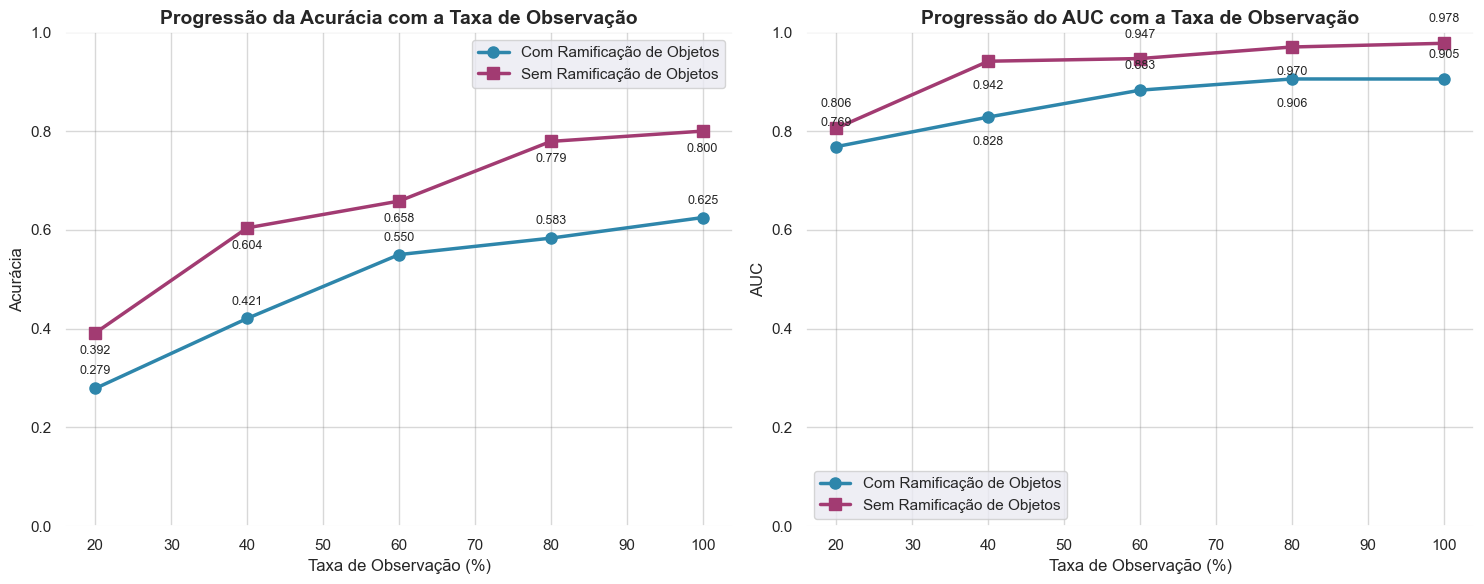


QUANTITATIVE METRICS SUMMARY TABLE
Obs Rate   With Obj Acc Without Obj Acc With Obj AUC Without Obj AUC
--------------------------------------------------------------------------------
100%        0.625        0.800           0.905        0.978          
80%        0.583        0.779           0.906        0.970          
60%        0.550        0.658           0.883        0.947          
40%        0.421        0.604           0.828        0.942          
20%        0.279        0.392           0.769        0.806          

PERFORMANCE DIFFERENCE ANALYSIS
Obs Rate   Acc Difference  AUC Difference 
------------------------------------------------------------
100%        -0.175          -0.072         
80%        -0.196          -0.065         
60%        -0.108          -0.064         
40%        -0.183          -0.113         
20%        -0.112          -0.037         


In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_metrics_progression(dataset_validation, observation_rates):
    """
    Plot accuracy and macro AUC progression over observation rates.
    
    Args:
        dataset_validation: DatasetValidation object containing results
        observation_rates: List of observation rates (e.g., [100, 80, 60, 40, 20])
    """
    # Extract metrics
    with_obj_accuracy = []
    without_obj_accuracy = []
    with_obj_macro_auc = []
    without_obj_macro_auc = []
    
    for obs_rate in observation_rates:
        # Get validation results for this observation rate
        validation_results = dataset_validation[obs_rate]
        
        # Extract metrics for with object branch
        with_obj_metrics = validation_results.with_object_branch.quantitative_metrics
        with_obj_accuracy.append(with_obj_metrics.accuracy)
        with_obj_macro_auc.append(with_obj_metrics.macro_auc)
        
        # Extract metrics for without object branch
        without_obj_metrics = validation_results.without_object_branch.quantitative_metrics
        without_obj_accuracy.append(without_obj_metrics.accuracy)
        without_obj_macro_auc.append(without_obj_metrics.macro_auc)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), facecolor='white')
    fig.patch.set_facecolor('white')
    
    # Plot 1: Accuracy Progression
    ax1.set_facecolor('white')
    ax1.plot(observation_rates, with_obj_accuracy, 
             marker='o', linewidth=2.5, markersize=8, 
             color='#2E86AB', label=CHARTS_LABELS.with_object_branch)
    ax1.plot(observation_rates, without_obj_accuracy, 
             marker='s', linewidth=2.5, markersize=8, 
             color='#A23B72', label=CHARTS_LABELS.without_object_branch)
    
    ax1.set_xlabel(CHARTS_LABELS.quantitative_observation_rate, fontsize=12)
    ax1.set_ylabel(CHARTS_LABELS.quantitative_accuracy, fontsize=12)
    ax1.set_title(CHARTS_LABELS.quantitative_accuracy_progression_over_observation_rate, fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=1)
    ax1.set_ylim(0, 1)  # Accuracy is typically 0-1
    
    # Add value annotations
    for i, (obs_rate, with_acc, without_acc) in enumerate(zip(observation_rates, with_obj_accuracy, without_obj_accuracy)):
        ax1.annotate(f'{with_acc:.3f}', 
                    (obs_rate, with_acc), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)
        ax1.annotate(f'{without_acc:.3f}', 
                    (obs_rate, without_acc), 
                    textcoords="offset points", 
                    xytext=(0,-15), 
                    ha='center', fontsize=9)
    
    # Plot 2: Macro AUC Progression
    ax2.set_facecolor('white')
    ax2.plot(observation_rates, with_obj_macro_auc, 
             marker='o', linewidth=2.5, markersize=8, 
             color='#2E86AB', label=CHARTS_LABELS.with_object_branch)
    ax2.plot(observation_rates, without_obj_macro_auc, 
             marker='s', linewidth=2.5, markersize=8, 
             color='#A23B72', label=CHARTS_LABELS.without_object_branch)
    
    ax2.set_xlabel(CHARTS_LABELS.quantitative_observation_rate, fontsize=12)
    ax2.set_ylabel(CHARTS_LABELS.quantitative_auc, fontsize=12)
    ax2.set_title(CHARTS_LABELS.quantitative_auc_progression_over_observation_rate, fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=1)
    ax2.set_ylim(0, 1)  # AUC is typically 0-1
    
    # Add value annotations with alternating positions
    for i, (obs_rate, with_auc, without_auc) in enumerate(zip(observation_rates, with_obj_macro_auc, without_obj_macro_auc)):
        # Alternate positions: even indices above, odd indices below
        if i % 2 == 0:  # Even indices (0, 2, 4...) - place above
            ax2.annotate(f'{with_auc:.3f}', 
                        (obs_rate, with_auc), 
                        textcoords="offset points", 
                        xytext=(0, 15), 
                        ha='center', fontsize=9)
            ax2.annotate(f'{without_auc:.3f}', 
                        (obs_rate, without_auc), 
                        textcoords="offset points", 
                        xytext=(0, 15), 
                        ha='center', fontsize=9)
        else:  # Odd indices (1, 3...) - place below
            ax2.annotate(f'{with_auc:.3f}', 
                        (obs_rate, with_auc), 
                        textcoords="offset points", 
                        xytext=(0, -20), 
                        ha='center', fontsize=9)
            ax2.annotate(f'{without_auc:.3f}', 
                        (obs_rate, without_auc), 
                        textcoords="offset points", 
                        xytext=(0, -20), 
                        ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("QUANTITATIVE METRICS SUMMARY TABLE")
    print("="*80)
    print(f"{'Obs Rate':<10} {'With Obj Acc':<12} {'Without Obj Acc':<15} {'With Obj AUC':<12} {'Without Obj AUC':<15}")
    print("-"*80)
    
    for i, obs_rate in enumerate(observation_rates):
        print(f"{obs_rate}%{'':<7} {with_obj_accuracy[i]:<12.3f} {without_obj_accuracy[i]:<15.3f} "
              f"{with_obj_macro_auc[i]:<12.3f} {without_obj_macro_auc[i]:<15.3f}")
    
    # Calculate performance differences
    print("\n" + "="*60)
    print("PERFORMANCE DIFFERENCE ANALYSIS")
    print("="*60)
    print(f"{'Obs Rate':<10} {'Acc Difference':<15} {'AUC Difference':<15}")
    print("-"*60)
    
    for i, obs_rate in enumerate(observation_rates):
        acc_diff = with_obj_accuracy[i] - without_obj_accuracy[i]
        auc_diff = with_obj_macro_auc[i] - without_obj_macro_auc[i]
        print(f"{obs_rate}%{'':<7} {acc_diff:<15.3f} {auc_diff:<15.3f}")

# Usage in your notebook
plot_quantitative_metrics_progression(dataset_validation, OBSERVATION_RATE)

### Qualitative Comparison

- Graphic Analysis - Plotting with t-SNE
- Progression over observation rate

#### EAR (Early Action Recognition) Validation

t-SNE Visualization for Observation Rate: 100%


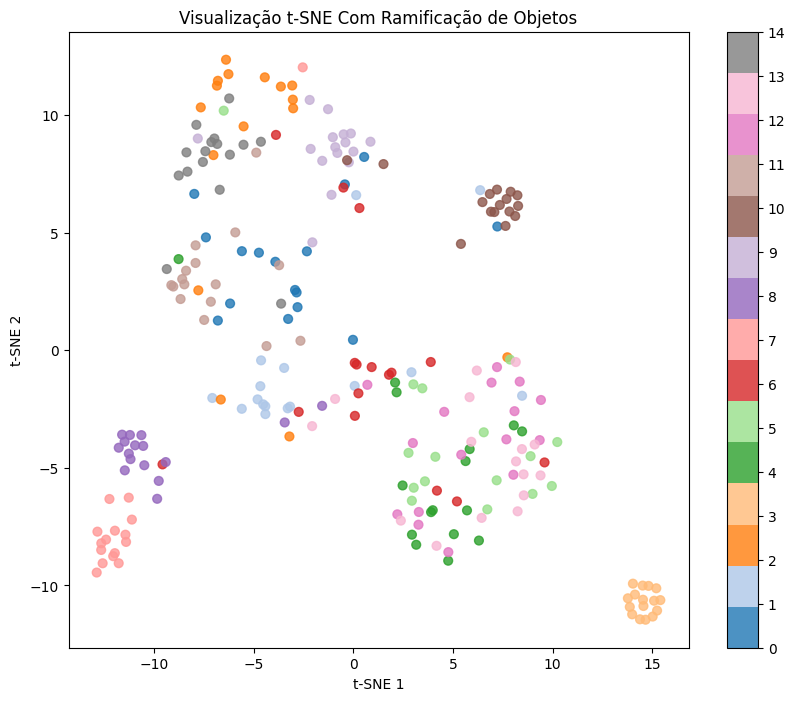

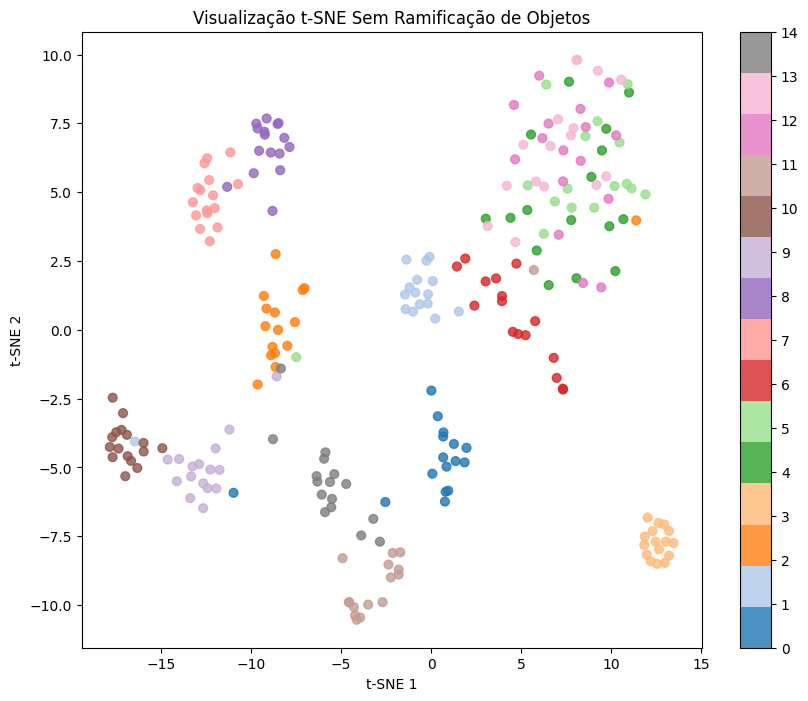

--------------------------------------------------
t-SNE Visualization for Observation Rate: 80%


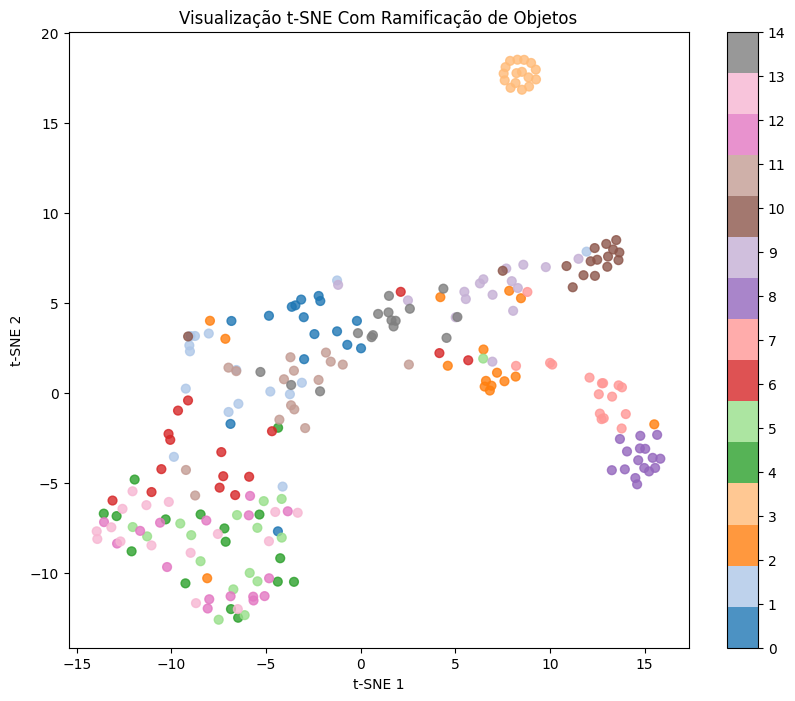

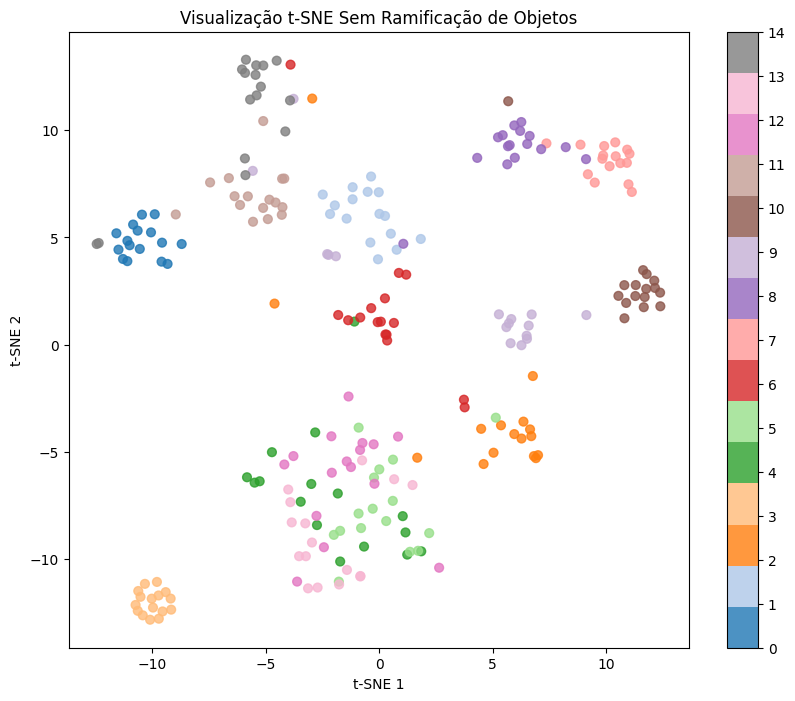

--------------------------------------------------
t-SNE Visualization for Observation Rate: 60%


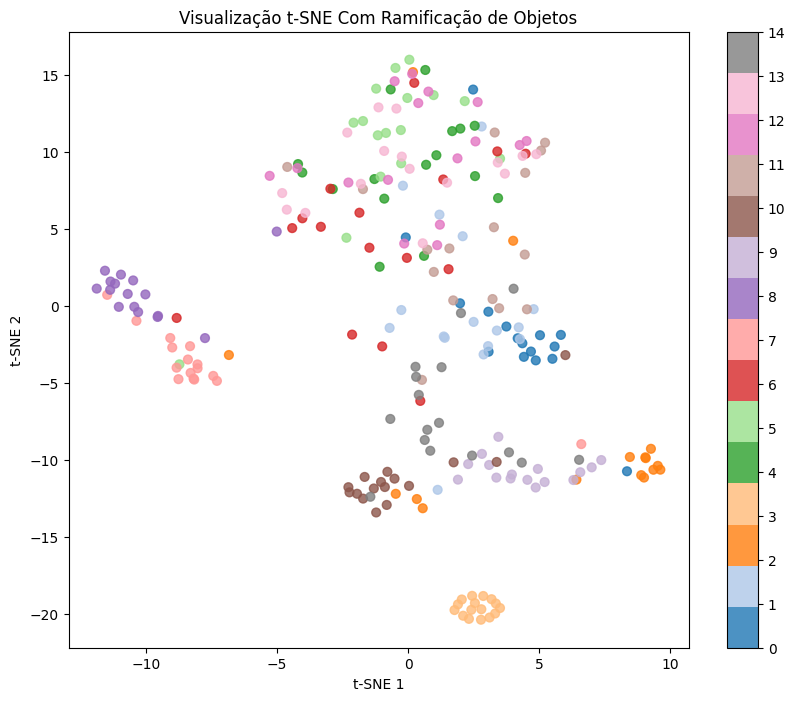

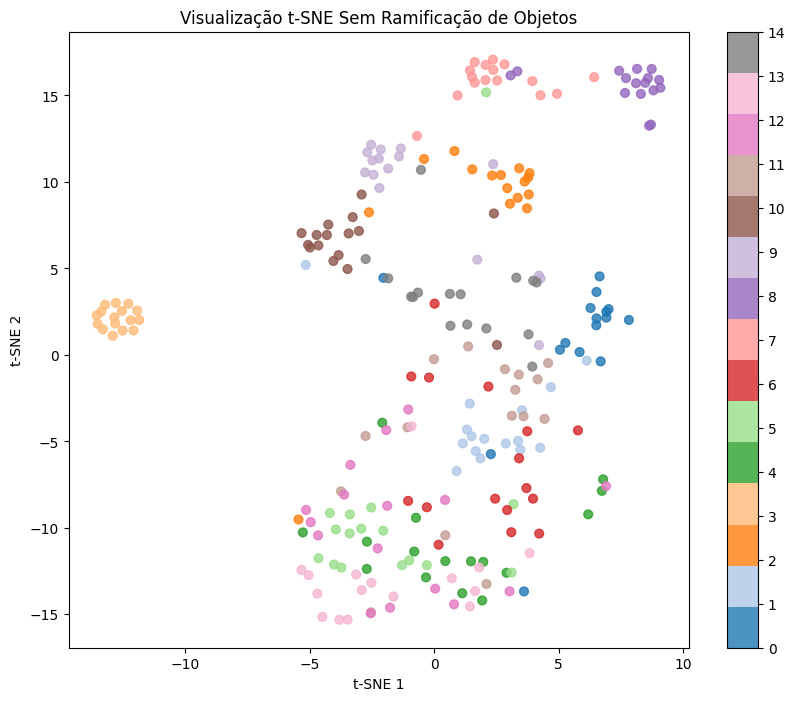

--------------------------------------------------
t-SNE Visualization for Observation Rate: 40%


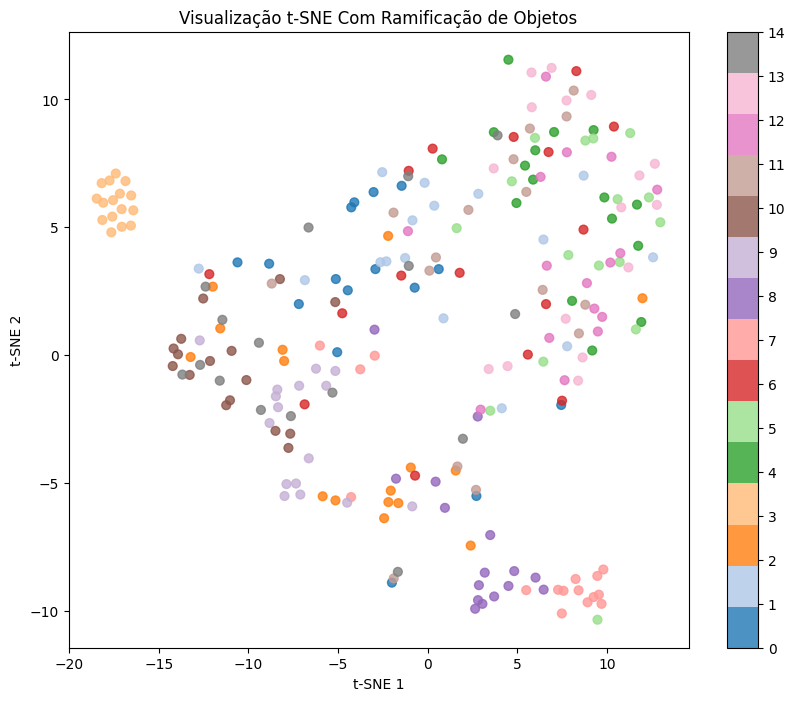

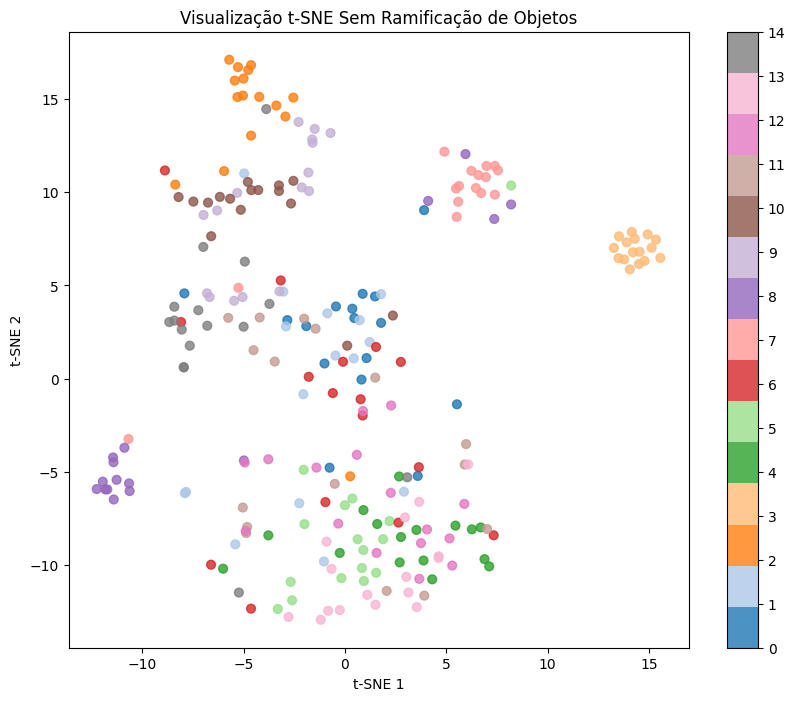

--------------------------------------------------
t-SNE Visualization for Observation Rate: 20%


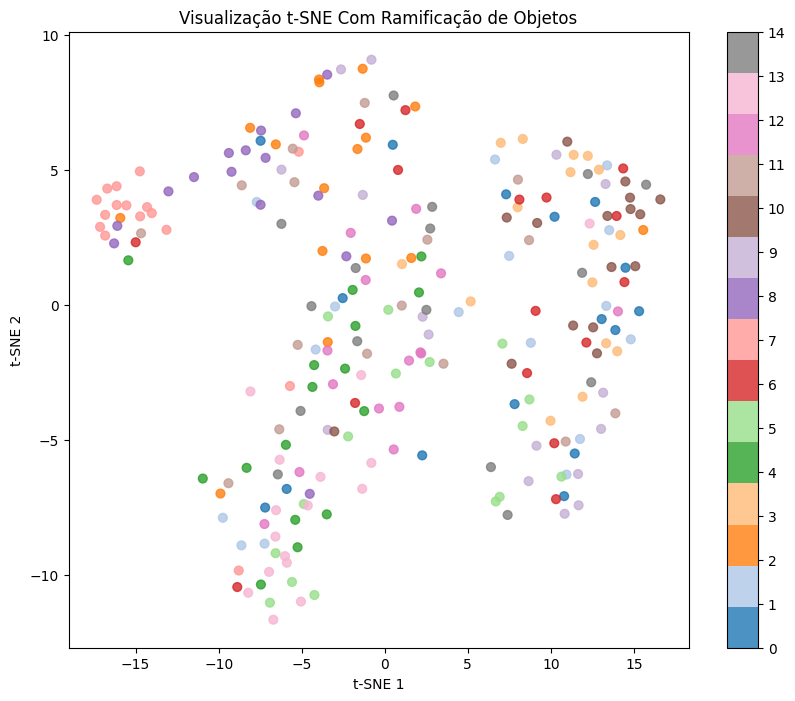

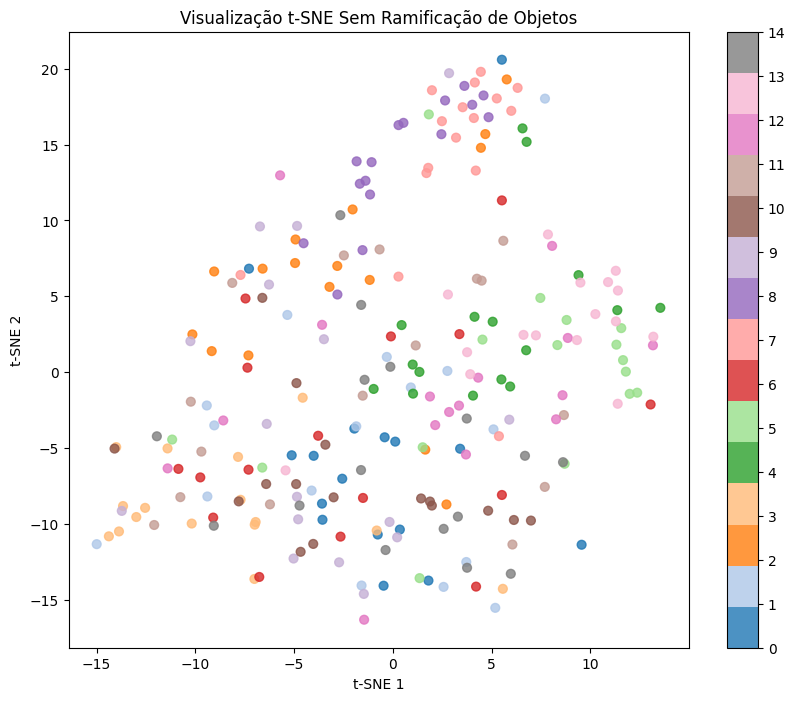

--------------------------------------------------


In [10]:
from sklearn.manifold import TSNE
perplexity = 30
random_state = 42
t_sne_components = 2

for obs_rate in OBSERVATION_RATE:
    embeddings, labels = dataset_validation[obs_rate].with_object_branch.embeddings
    embeddings_without_object, labels_without_object = dataset_validation[obs_rate].without_object_branch.embeddings


    tsne = TSNE(
        n_components=t_sne_components,
        perplexity=perplexity,
        random_state=random_state,
        init="pca"
    )
    reduced = tsne.fit_transform(embeddings)

    tsne_without_object = TSNE(
        n_components=t_sne_components,
        perplexity=perplexity,
        random_state=random_state,
        init="pca"
    )
    reduced_without_object = tsne_without_object.fit_transform(embeddings_without_object)
    
    print(f"t-SNE Visualization for Observation Rate: {obs_rate}%")
    visualize_tsne(
        reduced,
        labels,
        num_classes=15,
        n_components=t_sne_components,
        title=CHARTS_LABELS.t_sne_visualization + " " + CHARTS_LABELS.with_object_branch
    )
    visualize_tsne(
        reduced_without_object,
        labels_without_object,
        num_classes=15,
        n_components=t_sne_components,
        title=CHARTS_LABELS.t_sne_visualization + " " + CHARTS_LABELS.without_object_branch
    )
    print("--------------------------------------------------")

## Actions Table

In [11]:
from pathlib import Path
import sys
import os
sys.path.append(str(Path(os.getcwd()).parent))
from validation.actions_map import NTU_RGBD_60_ACTIONS, NTU_RGBD_ACTIONS_ORDER


NTU_RGB_ORDERED_ACTIONS = [NTU_RGBD_60_ACTIONS[action_code] for action_code in NTU_RGBD_ACTIONS_ORDER]

print(NTU_RGB_ORDERED_ACTIONS)

['Drink water', 'Eat meal', 'Brush hair', 'Pick up', 'Reading', 'Writing', 'Tear up paper', 'Put on a jacket', 'Take off a jacket', 'Put on hat', 'Take off hat', 'Phone call', 'Play with phone/tablet', 'Type on keyboard', 'Taking a selfie']


### LateX Table

```latex
\begin{table}[h!]
\centering
\caption{Mapeamento entre índices das classes e ações consideradas no subconjunto do dataset NTU RGB+D, utilizado para análise qualitativa das projeções t-SNE.}
\label{tab:ntu_rgbd_subset_tsne_classes}
\scriptsize
\begin{tabular}{c l}
\hline
\textbf{Classe} & \textbf{Ação} \\
\hline
0  & Drink water \\
1  & Eat meal \\
2  & Brush hair \\
3  & Pick up \\
4  & Reading \\
5  & Writing \\
6  & Tear up paper \\
7  & Put on a jacket \\
8  & Take off a jacket \\
9  & Put on hat \\
10 & Take off hat \\
11 & Phone call \\
12 & Play with phone/tablet \\
13 & Type on keyboard \\
14 & Taking a selfie \\
\hline
\end{tabular}
\end{table}
```

## Confusion Matrix

Confusion matrix will be only plotted for 100% trained models

In [12]:
from validation.confusion_matrix import calculate_confusion_matrix


har_model, _ = MultiModalHARModel.load(
    checkpoint_path=MODELS_PHT[100]["with_obj"]
)
cm = calculate_confusion_matrix(har_model, validation_dataset, device="cpu")

har_model_without_object, _ = MultiModalHARModel.load(
    checkpoint_path=MODELS_PHT[100]["without_obj"]
)
cm_without_object = calculate_confusion_matrix(har_model_without_object, validation_dataset, device="cpu")

2026-02-08 10:39:38,929 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/NTU-RGBD-60/model/har_model_v1.0.1_ntu_rgbd_60_100_with_obj_20251219_101648.pht...
2026-02-08 10:39:39,178 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:39:39,178 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 15, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2026-02-08 10:39:39,194 - INFO - ✅ Model loaded and ready for inference
2026-02-08 10:39:48,537 - INFO - Loading model from /Volumes/KODAK/ma

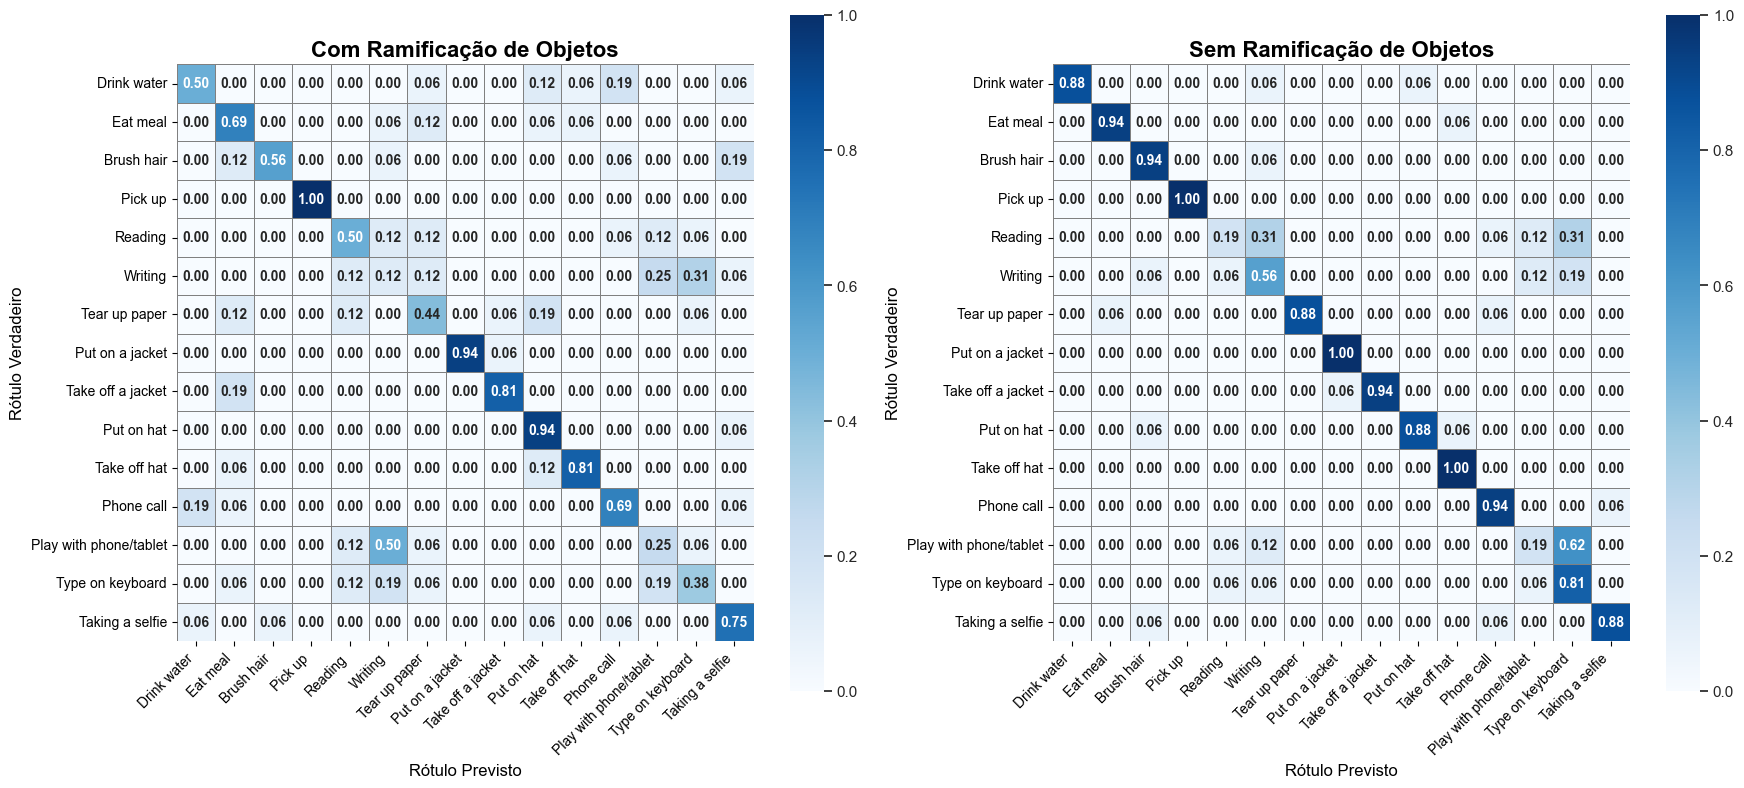

In [13]:
from validation.plots import plot_confusion_matrix


plot_confusion_matrix(
    with_object_cm=cm,
    class_names=NTU_RGB_ORDERED_ACTIONS,
    without_object_cm=cm_without_object,
)
